# Creative extension analysis notebook

---

**Authors**

- Jérémy Bensoussan
- Ekaterina Kryukova
- Jules Triomphe

---

This study aims to create a new Twitter dataset to evaluate the claim from Liang and Fu that "Twitter users who receive attention from more people will post more frequently than those who receive less attention".

---

## Initialisation

Import modules.

In [1]:
import os
import errno
import random
import time

from datetime import datetime, timezone
from tqdm.auto import tqdm, trange

import numpy as np
import pandas as pd

import requests

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.rcParams["figure.figsize"] = (12, 8)
plt.style.use("seaborn-whitegrid")

import statsmodels.api as sm

from pyspark import SparkContext
from pyspark.sql import *
from pyspark.sql.functions import split, explode, col

import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

Setup automatic formatting (requires the `nb-black` package).

In [2]:
# Enable auto-formatting

%load_ext lab_black

### Control center

**This is the control center. All operations are decided here to avoid memory overflow and excessive computation times. This notebook should be run FROM THE TOP once these parameters have been set.** If in doubt, ask Jules ;)

In [3]:
# Define constants

# UserID range
LOWER_ID_N = 0
UPPER_ID_N = int(3e9)

# UserID number
N_UID_PER_REQUEST = int(3e4)
N_UID_REQUESTS = 3

# --------------------------------------------------

# Choose whether to generate new UserIDs
CREATE_NEW_UIDs = False

# Choose whether to collect user data
COLLECT_USER_DATA = False
# Select the batch to query if collecting user data
REQUEST_NUMBER = 2
# Define behaviour depending on the run number.
# If this is True then COLLECT_USER_DATA must be True
FIRST_RUN = False

# Chooser whether to create user subset files
CREATE_USER_SUBSETS = False

# Choose whether to create/reset data pull status
# This also controls whether the PUBLIC_USERS_TIMELINES_FILE is overwritten
CREATE_DATA_PULL_STATUS = False
# Select the users to pull (from public_users_w_tweets)
PULL_START = 17000
PULL_END = PULL_START + 397  # 1000
# Choose whether to pull new data and save it
PULL_NEW_TIMELINE_DATA = False
N_RUNS_TIMELINE_DATA = 100
# Choose whether to save newly pulled data
SAVE_PULLED_DATA = False

# Choose whether to do the analysis
PERFORM_ANALYSIS = True

# --------------------------------------------------

# Data folder location
DATA_FOLDER = "./data/"
# UIDs
UIDS_FILE = DATA_FOLDER + "uids.csv"
# User files
USERS_FOLDER = DATA_FOLDER + "users/"
USERS_FILE = USERS_FOLDER + "users.csv"
PUBLIC_USERS_FILE = USERS_FOLDER + "public_users.csv"
PUBLIC_USERS_W_TWEETS_FILE = USERS_FOLDER + "public_users_w_tweets.csv"
# Pulled data
PUBLIC_USERS_PULL_STATUS_FILE = (
    DATA_FOLDER + f"public_users_pull_status_{PULL_START:05}_to_{PULL_END:05}.csv"
)
# Timeline files
TIMELINES_FOLDER = DATA_FOLDER + "timelines/"
PUBLIC_USERS_TIMELINES_FILE_PREFIX = TIMELINES_FOLDER + "public_users_timelines_"
PUBLIC_USERS_TIMELINES_FILE = (
    PUBLIC_USERS_TIMELINES_FILE_PREFIX + f"{PULL_START:05}_to_{PULL_END:05}.csv"
)
# File containing the bearer token
BEARER_TOKEN = DATA_FOLDER + "bearer_token.auth"
# Result files
RESULTS_FOLDER = DATA_FOLDER + "results/"
# Plot files
PLOT_FILE_SUFFIX = "_plot.png"
FOLLOWERS_PLOT_FILE = RESULTS_FOLDER + "followers" + PLOT_FILE_SUFFIX
FOLLOWERS_PLOT_NO_TITLE_FILE = RESULTS_FOLDER + "followers_no_title" + PLOT_FILE_SUFFIX
FOLLOWEES_PLOT_FILE = RESULTS_FOLDER + "followees" + PLOT_FILE_SUFFIX
FOLLOWEES_PLOT_NO_TITLE_FILE = RESULTS_FOLDER + "followees_no_title" + PLOT_FILE_SUFFIX
FRIENDS_PLOT_FILE = RESULTS_FOLDER + "friends" + PLOT_FILE_SUFFIX
FRIENDS_PLOT_NO_TITLE_FILE = RESULTS_FOLDER + "friends_no_title" + PLOT_FILE_SUFFIX

# API endpoints
API_USERS_ENDPOINT = "https://api.twitter.com/2/users?ids="
API_USER_FIELDS = "user.fields=created_at,id,protected,public_metrics,username,verified"
# API_USER_FIELDS = "user.fields=created_at,description,entities,id,location,name,pinned_tweet_id,protected,public_metrics,url,username,verified,withheld"
API_TWEET_FIELDS = "tweet.fields="
# API_TWEET_FIELDS = "tweet.fields=attachments,author_id,context_annotations,conversation_id,created_at,entities,geo,id,in_reply_to_user_id,lang,non_public_metrics,public_metrics,organic_metrics,promoted_metrics,possibly_sensitive,referenced_tweets,reply_settings,source,text,withheld"
API_V1_RATE_LIMITS = "https://api.twitter.com/1.1/application/rate_limit_status.json?resources=application,statuses,followers,friends"
API_USER_TIMELINE_ENDPOINT = "https://api.twitter.com/1.1/statuses/user_timeline.json"

# Random seed
SEED = 30
random.seed(SEED)

Let's create the folders if they do not exist.

In [4]:
for folder in [DATA_FOLDER, USERS_FOLDER, TIMELINES_FOLDER, RESULTS_FOLDER]:
    if not os.path.exists(folder):
        os.makedirs(folder)

---

## Data collection

In this part, we will generate random user IDs and collect their respective user information if they exist.

### UID generation

Let's create random UIDs in the 0-3 billion range as discussed in the abstract.

We reshape them to simplify queries due to Twitter's API's rate limits.

If they have already been generated, we load them.

In [5]:
if CREATE_NEW_UIDs:
    uids = pd.DataFrame(
        np.array(
            random.sample(
                range(LOWER_ID_N, UPPER_ID_N), N_UID_PER_REQUEST * N_UID_REQUESTS
            )
        ).reshape(N_UID_PER_REQUEST, N_UID_REQUESTS)
    )
    uids.to_csv(UIDS_FILE, index=False)
else:
    uids = pd.read_csv(UIDS_FILE)

### Token load

To query Twitter's API, we need a bearer token which we load.

In [6]:
# Load bearer token
with open(BEARER_TOKEN, "r") as file:
    token = file.readline().strip("\n")

# Define authentication header
headers = {"Authorization": "Bearer " + token}

### User data collection

In this section, we will get user data from Twitter's API.

First we define a few helper functions.

In [7]:
def wait_for_reset(r):
    print(
        "Current time: {} (UTC)".format(datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S"))
    )
    # Get reset time (Unix format)
    ts = int(r.headers["x-rate-limit-reset"])
    ts_str = datetime.fromtimestamp(ts).strftime("%Y-%m-%d %H:%M:%S")
    # Compute difference between current time and reset time
    sleep_time = (datetime.fromtimestamp(ts) - datetime.utcnow()).total_seconds()
    if sleep_time > 0:
        print("Waiting until {} (UTC) for the rate limit to reset.".format(ts_str))
        time.sleep(sleep_time)
    else:
        print("Reset time was: {} (UTC)".format(ts_str))
    print("Resuming user data collection")


def get_user_data(req, headers=headers, wait=True):
    # Query the user data
    r = requests.get(req, headers=headers)
    if wait & (int(r.headers["x-rate-limit-remaining"]) == 0):
        wait_for_reset(r)

        # Query the user data
        r = requests.get(req, headers=headers)

    return r


def get_user_data_df(r):
    df = pd.DataFrame(
        r.json()["data"],
        columns=[
            "id",
            "username",
            "protected",
            "verified",
            "created_at",
            "public_metrics",
        ],
        # Replace NaNs by empty strings to facilitate pre-processing
    ).fillna("")
    return df

Now, let's query the API.

In [8]:
# Get user data
if COLLECT_USER_DATA:
    for i in trange(N_UID_PER_REQUEST // 100):
        # Get 100 UserIDs (limit per request as defined by Twitter)
        users = uids.values[i * 100 : (i + 1) * 100, REQUEST_NUMBER]
        # Define the request URL
        req = (
            API_USERS_ENDPOINT
            + ",".join([str(user) for user in users])
            + "&"
            + API_USER_FIELDS
            + "&"
            + API_TWEET_FIELDS
        )

        # Create the dataframe on the first iteration
        if i == 0:
            # Query the user data
            r = get_user_data(req)

            # Check the response code
            print(r)

            # If the rate limit is not maximal, then wait for the reset to occur
            # (max 15 minutes)
            if int(r.headers["x-rate-limit-remaining"]) != 299:
                wait_for_reset(r)

                # Query the user data
                r = get_user_data(req)

            raw_user_data = get_user_data_df(r)
        # Append to existing dataframe on other iterations
        # but do not wait for reset for the last iteration
        elif i == 299:
            # Query the user data
            r = get_user_data(req, wait=False)
            # Append new data to existing dataframe
            raw_user_data = raw_user_data.append(get_user_data_df(r))
        else:
            # Query the user data
            r = get_user_data(req)
            # Append new data to existing dataframe
            raw_user_data = raw_user_data.append(get_user_data_df(r))

There are a few important data points we will need to the next parts so we extract them here along with any others they are grouped with.

In [9]:
# Preprocess the data


def get_key_val(x, key):
    """Get dictionary value from key if it exists, otherwise return an empty string."""
    if key in x:
        return x[key]
    else:
        return ""


def get_public_metrics(df):
    """Extract the data from the public_metrics column"""
    for metric in ["followers_count", "following_count", "tweet_count", "listed_count"]:
        df[metric] = df.public_metrics.apply(lambda x: get_key_val(x, metric))
    df.pop("public_metrics")
    return df


def get_entities(df):
    """Extract the data from the entity column"""
    for entity in ["url", "description"]:
        df["entities_" + entity] = df.entities.apply(lambda x: get_key_val(x, entity))
    df.pop("entities")
    return df


if COLLECT_USER_DATA:
    raw_user_data = get_public_metrics(raw_user_data)
    #     raw_user_data = get_entities(raw_user_data)
    raw_user_data = raw_user_data.astype(
        {
            "id": int,
            "username": str,
            "protected": bool,
            "verified": bool,
            "created_at": str,
            "followers_count": int,
            "following_count": int,
            "tweet_count": int,
            "listed_count": int,
        }
    )
    print("Number of valid users: {:,}".format(raw_user_data.shape[0]))
    raw_user_data

We need all of the user data available for the next parts, so we append the generated data (if any) to pre-existing user data and we save the data frame.

In [10]:
# Load user data if it exists
if os.path.isfile(USERS_FILE) and not FIRST_RUN:
    user_data = pd.read_csv(
        USERS_FILE,
        dtype={
            "id": int,
            "username": str,
            "protected": bool,
            "verified": bool,
            "created_at": str,
            "followers_count": int,
            "following_count": int,
            "tweet_count": int,
            "listed_count": int,
        },
        lineterminator="\n",
    )
    if COLLECT_USER_DATA:
        user_data = user_data.append(raw_user_data)
else:
    user_data = raw_user_data

if COLLECT_USER_DATA:
    # Save data to disk
    user_data.to_csv(USERS_FILE, index=False)

# Print statistics
print("Total number of valid users: {:,}".format(user_data.shape[0]))
print(
    "Total number of public users: {:,}".format(
        user_data[~user_data.protected].shape[0]
    )
)

Total number of valid users: 33,511
Total number of public users: 31,230


### User subset definition

We define and save groups of users to facilitate data manipulation later on.

In [11]:
# Extract user subsets
if CREATE_USER_SUBSETS:
    # Public users
    public_users = user_data[~user_data.protected].copy()
    # Public users with tweets
    # Tweet count includes retweets and deleted tweets
    public_users_w_tweets = user_data[
        ~user_data.protected & (user_data.tweet_count > 0)
    ].copy()

    print("Number of public users: {:,}".format(public_users.shape[0]))
    print(
        "Number of public users with tweets: {:,}".format(
            public_users_w_tweets.shape[0]
        )
    )

    public_users.to_csv(PUBLIC_USERS_FILE, index=False)
    public_users_w_tweets.to_csv(PUBLIC_USERS_W_TWEETS_FILE, index=False)

elif os.path.isfile(PUBLIC_USERS_W_TWEETS_FILE):
    public_users_w_tweets = pd.read_csv(
        PUBLIC_USERS_W_TWEETS_FILE,
        dtype={
            "id": int,
            "username": str,
            "protected": bool,
            "verified": bool,
            "created_at": str,
            "followers_count": int,
            "following_count": int,
            "tweet_count": int,
            "listed_count": int,
        },
    )
    print(
        "Number of public users with tweets: {:,}".format(
            public_users_w_tweets.shape[0]
        )
    )
else:
    raise FileNotFoundError(
        errno.ENOENT, os.strerror(errno.ENOENT), PUBLIC_USERS_W_TWEETS_FILE
    )

Number of public users with tweets: 17,397


### Data pull status generation

As there are many queries to make, we create here a dataframe to be able to keep track of what data was already pulled and what data still needs to be pulled.

In [12]:
# Create pull status dataframe
if CREATE_DATA_PULL_STATUS:
    # Use public metrics to define limits
    user_data_pull_status = public_users_w_tweets[["id", "tweet_count"]][
        PULL_START:PULL_END
    ].copy()

    # Define parameters for API queries
    user_data_pull_status["timeline_lowest_id"] = 0
    user_data_pull_status["timeline_tweets_pulled"] = 0

    # Change column order for easier visualization
    user_data_pull_status = user_data_pull_status[
        [
            "id",
            "timeline_lowest_id",
            "timeline_tweets_pulled",
            "tweet_count",
        ]
    ]

    # Set id column to index
    user_data_pull_status = user_data_pull_status.set_index("id")
    # Save to file
    user_data_pull_status.to_csv(PUBLIC_USERS_PULL_STATUS_FILE)

elif os.path.isfile(PUBLIC_USERS_PULL_STATUS_FILE):
    user_data_pull_status = pd.read_csv(
        PUBLIC_USERS_PULL_STATUS_FILE,
        dtype=int,
        index_col="id",
    )
else:
    raise FileNotFoundError(
        errno.ENOENT, os.strerror(errno.ENOENT), PUBLIC_USERS_PULL_STATUS_FILE
    )

### User timeline collection

As part of our analysis, we need to collect users' timelines. This is what we do here.

First we define a few helper functions whose names are pretty explicit, then we move on to actually query the data before saving it along with the data pull status.

In [13]:
def get_user_timeline_rate_limit():
    r = requests.get(API_V1_RATE_LIMITS, headers=headers)
    remaining = r.json()["resources"]["statuses"]["/statuses/user_timeline"][
        "remaining"
    ]
    # Get Unix timestamp
    reset_ts = r.json()["resources"]["statuses"]["/statuses/user_timeline"]["reset"]
    # Convert to string
    reset_time = datetime.fromtimestamp(reset_ts).strftime("%Y-%m-%d %H:%M:%S")
    return remaining, reset_time


def get_initial_timeline_df():
    return pd.DataFrame(
        columns=[
            "user_id",
            "id",
            "user_mentions",
        ]
    )


def get_user_timeline_df(r):
    df = pd.DataFrame(
        r.json(),
        columns=[
            "user_id",
            # User profile
            "user",
            "id",
            # This feature contains the user mentions
            "entities",
            # This feature is expected to be NaN
            "user_mentions",
        ],
        # Replace NaNs by empty strings to facilitate pre-processing
    ).fillna("")
    # Fill in user_id with tweet UserID
    df.user_id = df.user.apply(lambda x: x["id"])

    def get_user_mentions_ids(x):
        users_mentioned = x["user_mentions"]
        user_mentions = []
        for i in range(len(users_mentioned)):
            user_mentions.append(users_mentioned[i]["id"])
        return ";".join(str(x) for x in user_mentions)

    df.user_mentions = df.entities.apply(lambda x: get_user_mentions_ids(x))
    df.drop(columns=["user", "entities"], inplace=True)
    return df


def get_user_timeline(query_n, user_id, max_id, count):
    req = API_USER_TIMELINE_ENDPOINT
    params = {
        "user_id": str(user_id),
        "count": str(count),
        "include_rts": "1",
    }
    if max_id > 0:
        params.update({"max_id": str(max_id - 1)})

    r = requests.get(req, headers=headers, params=params)
    df = get_user_timeline_df(r)

    n_tweets_pulled = len(r.json())
    if n_tweets_pulled < count:
        print(r.url)
        print(
            "Query {:,} -- ".format(query_n + 1).ljust(15)
            + "User {}: got {:,} tweets instead of {:,}.".format(
                user_id, n_tweets_pulled, count
            )
        )
        lowest_id = -1
    if df.shape[0] > 0:
        lowest_id = int(df.id.min())

    return df, lowest_id, n_tweets_pulled

Having defined our helper functions, we now create an empty dataframe for our user timeline data and query the API for as much data as possible until we hit the rate limit (similar sections are run multiple times (days...) to query all of the necessary data).

In [14]:
tmp_user_timeline_data = get_initial_timeline_df()

if PULL_NEW_TIMELINE_DATA:
    for n in range(N_RUNS_TIMELINE_DATA):
        print("\nStarting pull sequence...")

        # Clear the dataframe to avoid caching entries (happens often)
        del tmp_user_timeline_data
        # Load a new temporary dataframe
        tmp_user_timeline_data = get_initial_timeline_df()

        # Get the number of available queries and rate limit reset time
        query_quota, reset_time = get_user_timeline_rate_limit()

        # Get users with tweets left to pull
        user_timelines_to_pull = user_data_pull_status[
            (user_data_pull_status.tweet_count > 0)
            & (
                user_data_pull_status.timeline_tweets_pulled
                < user_data_pull_status.tweet_count
            )
            # The API limits pulls to the 3.2k most recent tweets
            & (user_data_pull_status.timeline_tweets_pulled < 3200)
        ]

        skip_sleep_time = user_timelines_to_pull.shape[0] < query_quota
        n_queries = min(query_quota, user_timelines_to_pull.shape[0])
        if n_queries > 0:
            print("Executing {:,} queries.".format(n_queries))
        else:
            print("\nNo more tweets to pull!\n")
            break
        for query_n in trange(n_queries):

            # Get query parameters
            user_id = user_timelines_to_pull.index[query_n]
            max_id = user_timelines_to_pull.loc[user_id, "timeline_lowest_id"]
            # A 200-tweet limit is set by Twitter per request
            count = min(
                min(user_timelines_to_pull.loc[user_id, "tweet_count"], 3200)
                - user_timelines_to_pull.loc[user_id, "timeline_tweets_pulled"],
                200,
            )

            # Get user timeline data and statistics
            raw_user_timeline_data, lowest_id, n_tweets_pulled = get_user_timeline(
                query_n, user_id, max_id, count
            )

            # Append to existing user timeline data
            tmp_user_timeline_data = tmp_user_timeline_data.append(
                raw_user_timeline_data
            )

            # Update pull status
            user_data_pull_status.loc[user_id, "timeline_lowest_id"] = lowest_id
            if user_timelines_to_pull.loc[user_id, "timeline_tweets_pulled"] == 0:
                user_data_pull_status.loc[user_id, "timeline_tweets_pulled"] = count
            else:
                user_data_pull_status.loc[user_id, "timeline_tweets_pulled"] += count

        print("Next reset time: {} (UTC)".format(reset_time))

        print("\nPull is done!\n")

        # Define user timelines dataframe
        if os.path.isfile(PUBLIC_USERS_TIMELINES_FILE) and not CREATE_DATA_PULL_STATUS:
            # Clear the dataframe to avoid caching entries (happens often)
            del user_timeline_data
            # Load the dataframe back
            user_timeline_data = pd.read_csv(PUBLIC_USERS_TIMELINES_FILE)
            user_timeline_data = user_timeline_data.append(tmp_user_timeline_data)
        else:
            user_timeline_data = tmp_user_timeline_data

        print(
            "Number of collected tweets: {:,} ({:,} unique) out of {:,}.\nNumber of unique users: {:,} (out of {:,}).".format(
                user_timeline_data.shape[0],
                len(np.unique(user_timeline_data.id.values)),
                np.sum(
                    user_data_pull_status.tweet_count.map(lambda x: min(x, 3200)).values
                ),
                len(np.unique(user_timeline_data.user_id.values)),
                user_data_pull_status.shape[0],
            )
        )

        if SAVE_PULLED_DATA:
            # Save data to disk
            user_timeline_data.to_csv(PUBLIC_USERS_TIMELINES_FILE, index=False)
            user_data_pull_status.to_csv(PUBLIC_USERS_PULL_STATUS_FILE)
            print("Data saved!")

        # Get new reset time
        query_quota, reset_time = get_user_timeline_rate_limit()

        # Sleep until rate limit reset
        sleep_time = (
            datetime.strptime(reset_time, "%Y-%m-%d %H:%M:%S") - datetime.utcnow()
        ).total_seconds()

        if sleep_time > 0 and not skip_sleep_time:
            print(
                "Waiting for {:,.0f} seconds to continue (until {} (UTC)).\n".format(
                    sleep_time, reset_time
                )
            )
            time.sleep(sleep_time)

    print("Loop is done!")

In [15]:
# Continue on to the next section
if not PERFORM_ANALYSIS:
    raise ValueError("The analysis will not be performed.")

---

## Data preprocessing

In this part, we manipulate the collected data to clean it and perform feature engineering.

### Loading the data

Let's start by loading the data with Spark.

In [16]:
# Create the session
spark = SparkSession.builder.getOrCreate()

# Create the context
sc = spark.sparkContext

In [17]:
# Load the timelines
timelines = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "true")
    .load(PUBLIC_USERS_TIMELINES_FILE_PREFIX + "*.csv")
)
# Rename the "id" column to be more explicit
timelines = timelines.withColumnRenamed("id", "tweet_id")
# Print the dataframe schema to check
print("Dataframe schema:")
timelines.printSchema()
print("There are {:,} tweets.".format(timelines.count()))
timelines_w_mentions = timelines.filter("user_mentions is not null")
timelines_w_mentions_len = timelines_w_mentions.count()
print("There are {:,} tweets with user mentions.".format(timelines_w_mentions_len))
print("\nSample of the timelines with mentions dataframe:")
timelines_w_mentions.show()

Dataframe schema:
root
 |-- user_id: string (nullable = true)
 |-- tweet_id: string (nullable = true)
 |-- user_mentions: string (nullable = true)

There are 4,999,405 tweets.
There are 2,436,137 tweets with user mentions.

Sample of the timelines with mentions dataframe:
+---------+------------------+-------------------+
|  user_id|          tweet_id|      user_mentions|
+---------+------------------+-------------------+
|750164550|234400157733625856|          620397692|
|750164550|234347463522283520|          164963639|
|750164550|234135138110418945|          454321120|
|750164550|234134919499100160|          614038801|
|750164550|234096289267216384|          548729028|
|750164550|234085306297626624|          164963639|
|750164550|234071618543026176|1276237573472555009|
|750164550|234070401943232512|          614038801|
|750164550|234067792947707904|          326930115|
|750164550|234063419882496001|          164963639|
|750164550|234062693139615744|          421358851|
|436813861|34

### Cleaning and feature engineering

Now that the data is loaded, it can be cleaned.

First, there are likely some duplicates in the data due to improper system caching and maybe the API as well. Therefore, these duplicates are dropped.

In [18]:
clean_timelines = timelines_w_mentions.dropDuplicates()
clean_timelines_len = clean_timelines.count()
print("There are {:,} unique tweets with user mentions.".format(clean_timelines_len))
print(
    "{:,} ({:.2%}) duplicate tweets with user mentions were dropped.".format(
        timelines_w_mentions_len - clean_timelines_len,
        (timelines_w_mentions_len - clean_timelines_len) / timelines_w_mentions_len,
    )
)
print("\nSample of the cleaned timelines with mentions dataframe:")
clean_timelines.show()

There are 2,426,816 unique tweets with user mentions.
9,321 (0.38%) duplicate tweets with user mentions were dropped.

Sample of the cleaned timelines with mentions dataframe:
+----------+-------------------+--------------------+
|   user_id|           tweet_id|       user_mentions|
+----------+-------------------+--------------------+
| 715982670| 475738631639146496|          1488891368|
| 336101508| 322448167054483457|           142092456|
|1517812970| 655554685391273986| 1290018194212741121|
|1517812970| 653808079138652160|          2791249352|
|2194961784| 401119160786092032|            10228272|
| 819057420| 296358015081279488|           819057420|
| 819057420| 296338042480906240|           819057420|
|2795737913| 528817384166273024|           296426412|
| 490700220|1109160267768827904|           601892162|
| 135748697| 583849610440880128|  16676396;302901861|
| 163477479| 971764013435641857|          3290992080|
| 560448122| 294992894715105281|           434325569|
|1710764114| 4

After cleaning, the mentioned users are still bundled together in the `user_mentions` column. We want to split them up to be able to identify which ones are egos' friends.

>*Note:* friends are defined as users who egos have mentioned at least twice.

In [19]:
clean_mentions = clean_timelines.select(
    clean_timelines.user_id,
    explode(split(col("user_mentions"), ";")).alias("user_mention"),
)
clean_mentions.show()

+----------+-------------------+
|   user_id|       user_mention|
+----------+-------------------+
| 715982670|         1488891368|
| 336101508|          142092456|
|1517812970|1290018194212741121|
|1517812970|         2791249352|
|2194961784|           10228272|
| 819057420|          819057420|
| 819057420|          819057420|
|2795737913|          296426412|
| 490700220|          601892162|
| 135748697|           16676396|
| 135748697|          302901861|
| 163477479|         3290992080|
| 560448122|          434325569|
|1710764114|1296463230546505728|
|1710764114|          288304848|
|1028981942|           40256008|
|1028981942|           40459831|
|1244581381|1004699571669348353|
|2481702381|           27610463|
|2481702381|          157997359|
+----------+-------------------+
only showing top 20 rows



Having cleaned the user mentions, we can now group them by ego ID and mentioned user ID.

In [20]:
user_mentions = (
    clean_mentions.groupBy("user_id", "user_mention")
    .count()
    .select(
        clean_mentions.user_id,
        clean_mentions.user_mention,
        col("count").alias("n_mentions"),
    )
)
user_mentions.show()

+----------+-------------------+----------+
|   user_id|       user_mention|n_mentions|
+----------+-------------------+----------+
|1239447073|          735860210|       150|
| 436813861|          228469466|         7|
|2946900256|          818839458|        97|
| 505372259|           21268897|         3|
|2346638574| 795332875746942976|         1|
| 219786752|           48347560|        32|
|2184448231|          181561712|        77|
|2339895992|          257396212|         4|
| 119586097|          222586828|         2|
| 119586097|          749952350|         2|
| 381669842|          294910913|         1|
| 413271014|         1072915220|         2|
| 256546351|         2545355988|        17|
| 330258174|         2309985656|         5|
| 632389508| 875531003401580544|        20|
| 452791095|          153420005|       219|
| 449722717|          250741662|         6|
|1632867464|           61517647|       268|
|1870882106|1097471710121480192|         2|
| 256500614|          516909654|

And finally we can filter friends.

In [21]:
user_mentions_gt2 = user_mentions.filter(user_mentions.n_mentions > 2)
print(
    "There are {:,} ego friends from {:,} unique egos.".format(
        user_mentions_gt2.count(),
        user_mentions_gt2.select("user_id").distinct().count(),
    )
)
user_mentions_gt2.show()

There are 173,537 ego friends from 6,532 unique egos.
+----------+------------------+----------+
|   user_id|      user_mention|n_mentions|
+----------+------------------+----------+
|1239447073|         735860210|       150|
| 436813861|         228469466|         7|
|2946900256|         818839458|        97|
| 505372259|          21268897|         3|
| 219786752|          48347560|        32|
|2184448231|         181561712|        77|
|2339895992|         257396212|         4|
| 256546351|        2545355988|        17|
| 330258174|        2309985656|         5|
| 632389508|875531003401580544|        20|
| 452791095|         153420005|       219|
| 449722717|         250741662|         6|
|1632867464|          61517647|       268|
| 256500614|         516909654|        20|
|1489483166|          15083162|         4|
|  59433911|         154986574|        32|
|  59433911|         303238212|         9|
| 752874206|          16344972|        54|
| 362134601|        1673586954|        12|


The size of the dataframe is small enough that we can load it into memory now.

In [22]:
user_mentions_df = user_mentions_gt2.toPandas()
user_mentions_df.head()

,user_id,user_mention,n_mentions
0,1239447073,735860210,150
1,436813861,228469466,7
2,2946900256,818839458,97
3,505372259,21268897,3
4,219786752,48347560,32


Next, as defined the paper, **only the users with at least one alter will be considered**. To prepare the analysis, the creation time of the accounts will be used to extract the mean number of tweets posted by each account per day of existence.

In [23]:
# Extract users with at least one alter
user_data_w_alters = user_data.query(
    "followers_count > 0 or following_count > 0"
).copy()
print(
    "There are {:,} users with at least one alter.".format(user_data_w_alters.shape[0])
)
# Convert creation dates to datetime
user_data_w_alters.created_at = pd.to_datetime(user_data_w_alters.created_at)
# Compute the mean daily number of tweets per user
user_data_w_alters[
    "mean_daily_tweets"
] = user_data_w_alters.tweet_count / user_data_w_alters.created_at.apply(
    lambda x: (datetime.now(tz=timezone.utc) - x.to_pydatetime()).days
)
user_data_w_alters.sample(n=5)

There are 26,825 users with at least one alter.


,id,username,protected,verified,created_at,followers_count,following_count,tweet_count,listed_count,mean_daily_tweets
18479,465614287,FSanitra,False,False,2012-01-16 15:09:03+00:00,8,43,3,0,0.000921
26790,2868146753,1s2d4f5g6h,False,False,2014-11-08 23:33:40+00:00,2,0,0,0,0.000000
28479,526570147,CanerGnes,False,False,2012-03-16 16:40:08+00:00,65,193,189,0,0.059099
11467,431113061,meswede61,False,False,2011-12-07 22:57:53+00:00,4,19,17,0,0.005155
33458,1721269686,AmarJyo94106346,True,False,2013-09-02 05:37:28+00:00,0,30,41,0,0.015390


Let's describe some of the dataset's features for mean number of daily tweets, followers and following count as well as tweet count.

In [24]:
user_data_w_alters[
    ["mean_daily_tweets", "followers_count", "following_count", "tweet_count"]
].describe()

,mean_daily_tweets,followers_count,following_count,tweet_count
count,26825.000000,26825.000000,26825.000000,26825.000000
mean,0.272171,69.104007,95.562647,853.499683
std,2.221473,598.765206,467.791151,6716.946275
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2.000000,0.000000
50%,0.000812,3.000000,13.000000,2.000000
75%,0.011023,15.000000,57.000000,33.000000
max,160.594329,44835.000000,34035.000000,441795.000000


It is also interesting to analyze the distribution of account creation dates.

In [25]:
# When users were created

users_days_since_creation = user_data_w_alters.created_at.apply(
    lambda x: (datetime.now(tz=timezone.utc) - x.to_pydatetime()).days
)
print("When users were created:")
print("\nIn days")
print(users_days_since_creation.describe())
print("\n In years")
print((users_days_since_creation / 365).describe())

When users were created:

In days
count    26825.000000
mean      3032.908220
std        573.705696
min       1045.000000
25%       2561.000000
50%       2961.000000
75%       3433.000000
max       5015.000000
Name: created_at, dtype: float64

 In years
count    26825.000000
mean         8.309338
std          1.571796
min          2.863014
25%          7.016438
50%          8.112329
75%          9.405479
max         13.739726
Name: created_at, dtype: float64


Although the time range that these account were created in is similar to that of the paper, interactions on Twitter have evolved since then, which is why it is acceptable to use tweets created long ago.

Let's observe the distribution users with certain levels of `tweet_counts` when their tweet count is above 0.

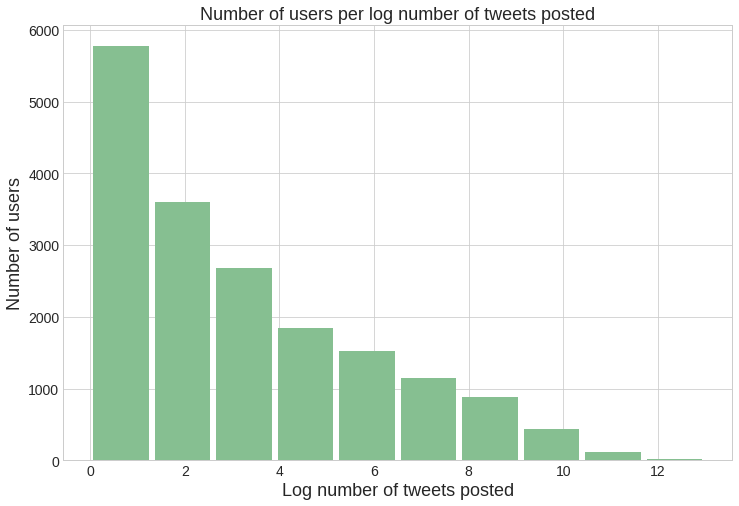

In [26]:
users_w_alters_and_tweets = user_data_w_alters.query("tweet_count > 0")[
    ["tweet_count"]
].copy()
users_w_alters_and_tweets["log_tweet_count"] = np.log(
    users_w_alters_and_tweets["tweet_count"]
)
axs = users_w_alters_and_tweets.hist(
    column="log_tweet_count",
    grid=True,
    color="#86bf91",
    zorder=2,
    rwidth=0.9,
)

ax = axs[0, 0]

plt.xlabel("Log number of tweets posted")
plt.ylabel("Number of users")
plt.title("Number of users per log number of tweets posted")


def format_plt(ax):
    # Change text size
    plt_text = [
        ax.title,
        ax.xaxis.label,
        ax.yaxis.label,
    ]
    plt_ticks = ax.get_xticklabels() + ax.get_yticklabels()

    for item in plt_text:
        item.set_fontsize(18)

    for item in plt_ticks:
        item.set_fontsize(14)


format_plt(ax)

plt.show()

The last step is to merge the two dataframes to link number of mentions and average daily productivity. Average productivity by friend number is computed by grouping by user first and counting their number of friends, then by grouping by friend number.

In [27]:
user_mentions_df.user_id = user_mentions_df.user_id.astype(int)
merged_mentions = pd.merge(
    user_mentions_df, user_data_w_alters, left_on="user_id", right_on="id"
)
merged_mentions.drop(columns=["id"], inplace=True)
merged_mentions.sample(n=5)

,user_id,user_mention,n_mentions,username,protected,verified,created_at,followers_count,following_count,tweet_count,listed_count,mean_daily_tweets
50541,2533478900,2565928944,4,ra_sda,False,False,2014-05-29 21:56:08+00:00,101,126,2982,0,1.245614
115378,350265961,705111209297715200,14,CrinaleEddie765,False,False,2011-08-07 13:50:16+00:00,363,2798,12423,2,3.632456
128481,119752727,503952168,13,mayupi0201,False,False,2010-03-04 14:59:07+00:00,149,126,11783,3,2.989850
70407,2243492864,1178277342914859008,21,___girlwholived,False,False,2013-12-13 07:04:28+00:00,354,232,4634,0,1.808743
5571,962794428,2231281639,27,maarich99,False,False,2012-11-21 17:49:11+00:00,161,344,6387,0,2.166554


In [28]:
friends = (
    merged_mentions.groupby("user_id")
    .agg({"n_mentions": lambda x: x.count(), "mean_daily_tweets": lambda x: x.mean()})
    .reset_index()
    .rename({"n_mentions": "n_friends"}, axis=1)
    .groupby("n_friends")
    .mean()
    .reset_index()
)
friends.head()

,n_friends,user_id,mean_daily_tweets
0,1,1.250634e+09,0.028855
1,2,1.215179e+09,0.073702
2,3,1.216892e+09,0.050976
3,4,1.180587e+09,0.076441
4,5,1.157385e+09,0.069192


## Graphical analysis

The authors of the paper have produced graphs to illustrate their results. We will do the same to compare.

Let's start with the average number of tweets as a function of the number of followers.

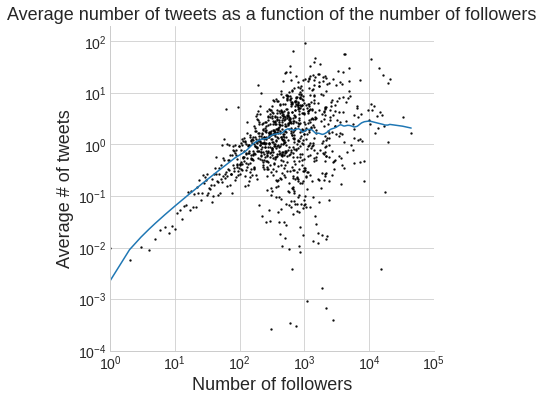

In [29]:
# Plot using the mean values of the mean daily number of tweets
# and the followers count

lowess = sm.nonparametric.lowess
mean_tweets_followers_count = (
    user_data_w_alters.groupby("followers_count").mean().reset_index()
)

x = mean_tweets_followers_count.followers_count.values
y = mean_tweets_followers_count.mean_daily_tweets.values
z = lowess(y, x, frac=1 / 5.95)

g = sns.lmplot(
    x="followers_count",
    y="mean_daily_tweets",
    data=mean_tweets_followers_count,
    fit_reg=False,
    aspect=1,
    scatter_kws={"s": 2, "color": "black"},
    height=5,
)

# Set axes to logscale and their limits
g.set(xscale="log", xlim=(1, 1e5), xlabel="Number of followers")
g.set(yscale="log", ylim=(1e-4, 2e2), ylabel="Average # of tweets")

# Plot loess
plt.plot(x, z[:, 1])

# Format text
format_plt(g.axes[0, 0])

# Save the figure without the title for the report
g.savefig(FOLLOWERS_PLOT_NO_TITLE_FILE, dpi=600)
# Add title
plt.title("Average number of tweets as a function of the number of followers")
# Reformat text
format_plt(g.axes[0, 0])
# Save the figure with the title
g.savefig(FOLLOWERS_PLOT_FILE, dpi=600)

plt.show()

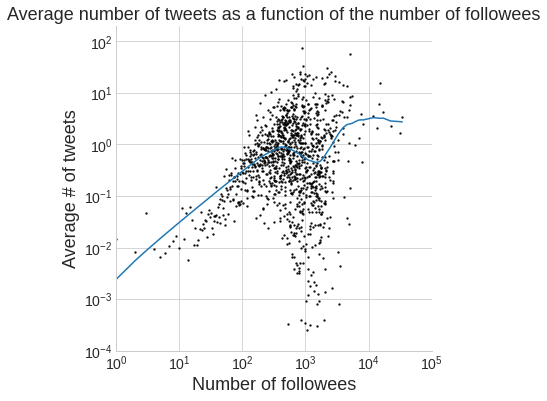

In [30]:
# Plot using the mean values of the mean daily number of tweets
# and the followees count

mean_tweets_following_count = (
    user_data_w_alters.groupby("following_count").mean().reset_index()
)

x = mean_tweets_following_count.following_count.values
y = mean_tweets_following_count.mean_daily_tweets.values
z = lowess(y, x, frac=1 / 3.08)

g = sns.lmplot(
    x="following_count",
    y="mean_daily_tweets",
    data=mean_tweets_following_count,
    fit_reg=False,
    aspect=1,
    scatter_kws={"s": 2, "color": "black"},
    height=5,
)

# Set axes to logscale and their limits
g.set(xscale="log", xlim=(1, 1e5), xlabel="Number of followees")
g.set(yscale="log", ylim=(1e-4, 2e2), ylabel="Average # of tweets")

# Plot loess
plt.plot(x, z[:, 1])

# Format text
format_plt(g.axes[0, 0])

# Save the figure without the title for the report
g.savefig(FOLLOWEES_PLOT_NO_TITLE_FILE, dpi=600)
# Add title
plt.title("Average number of tweets as a function of the number of followees")
# Reformat text
format_plt(g.axes[0, 0])
# Save the figure with the title
g.savefig(FOLLOWEES_PLOT_FILE, dpi=600)

plt.show()

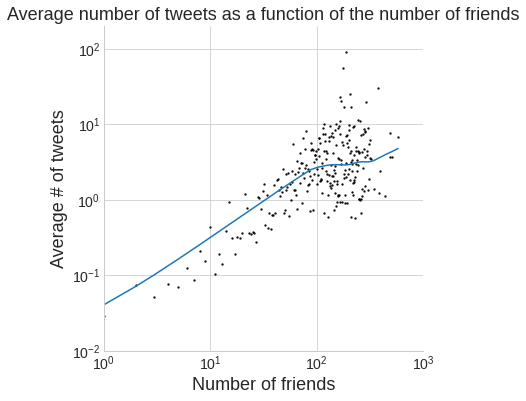

In [31]:
# Plot using the mean values of the mean daily number of tweets
# and the friend count

x = friends.n_friends.values
y = friends.mean_daily_tweets.values
z = lowess(y, x, frac=1 / 1.5)

g = sns.lmplot(
    x="n_friends",
    y="mean_daily_tweets",
    data=friends,
    fit_reg=False,
    aspect=1,
    scatter_kws={"s": 2, "color": "black"},
    height=5,
)

# Set axes to logscale and their limits
g.set(xscale="log", xlim=(1, 1e3), xlabel="Number of friends")
g.set(yscale="log", ylim=(1e-2, 2e2), ylabel="Average # of tweets")

# Plot loess
plt.plot(x, z[:, 1])

# Format text
format_plt(g.axes[0, 0])

# Save the figure without the title for the report
g.savefig(FRIENDS_PLOT_NO_TITLE_FILE, dpi=600)
# Add title
plt.title("Average number of tweets as a function of the number of friends")
# Reformat text
format_plt(g.axes[0, 0])
# Save the figure with the title
g.savefig(FRIENDS_PLOT_FILE, dpi=600)

plt.show()

## Numerical analysis

Now that the findings have been shown to be similar graphically, we still need to prove that our results are similar numerically. To do this, we will compare the Pearson correlations.

In [32]:
user_data_w_alters[
    ["mean_daily_tweets", "tweet_count", "followers_count", "following_count"]
].apply(lambda x: np.log(x)).corr(method="pearson")

,mean_daily_tweets,tweet_count,followers_count,following_count
mean_daily_tweets,1.000000,0.997615,0.745148,0.637600
tweet_count,0.997615,1.000000,0.747358,0.635568
followers_count,0.745148,0.747358,1.000000,0.730763
following_count,0.637600,0.635568,0.730763,1.000000


In [33]:
friends[["mean_daily_tweets", "n_friends"]].apply(lambda x: np.log(x)).corr(
    method="pearson"
)

,mean_daily_tweets,n_friends
mean_daily_tweets,1.000000,0.705758
n_friends,0.705758,1.000000


We also want to compute the t-statistic and the p-value for each of the three analyses.

In [34]:
ols = sm.OLS.from_formula(
    "mean_daily_tweets ~ followers_count", data=user_data_w_alters
)
ols_results = ols.fit()
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      mean_daily_tweets   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     1236.
Date:                Fri, 18 Dec 2020   Prob (F-statistic):          1.07e-264
Time:                        09:48:09   Log-Likelihood:                -58869.
No. Observations:               26825   AIC:                         1.177e+05
Df Residuals:                   26823   BIC:                         1.178e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2184      0.013     16.357      0.000       0.192       0.245
followers_count     0.0008   2.21e-05     35.153      0.000       0.001       0.001
==============================================================================
Omnibus:                    71031.247   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3052322253.450
Skew:                          31.396   Prob(JB):                         0.00
Kurtosis:                    1654.343   Cond. No.                         607.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
ols = sm.OLS.from_formula(
    "mean_daily_tweets ~ following_count", data=user_data_w_alters
)
ols_results = ols.fit()
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      mean_daily_tweets   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     657.9
Date:                Fri, 18 Dec 2020   Prob (F-statistic):          2.25e-143
Time:                        09:48:09   Log-Likelihood:                -59148.
No. Observations:               26825   AIC:                         1.183e+05
Df Residuals:                   26823   BIC:                         1.183e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2020      0.014     14.766      0.000       0.175       0.229
following_count     0.0007   2.86e-05     25.650      0.000       0.001       0.001
==============================================================================
Omnibus:                    70718.311   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2834918753.273
Skew:                          31.064   Prob(JB):                         0.00
Kurtosis:                    1594.385   Cond. No.                         487.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
ols = sm.OLS.from_formula(
    "mean_daily_tweets ~ followers_count", data=user_data_w_alters
)
ols_results = ols.fit()
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      mean_daily_tweets   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     1236.
Date:                Fri, 18 Dec 2020   Prob (F-statistic):          1.07e-264
Time:                        09:48:09   Log-Likelihood:                -58869.
No. Observations:               26825   AIC:                         1.177e+05
Df Residuals:                   26823   BIC:                         1.178e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2184      0.013     16.357      0.000       0.192       0.245
followers_count     0.0008   2.21e-05     35.153      0.000       0.001       0.001
==============================================================================
Omnibus:                    71031.247   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3052322253.450
Skew:                          31.396   Prob(JB):                         0.00
Kurtosis:                    1654.343   Cond. No.                         607.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
ols = sm.OLS.from_formula("mean_daily_tweets ~ n_friends", data=friends)
ols_results = ols.fit()
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      mean_daily_tweets   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     12.62
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           0.000452
Time:                        09:48:09   Log-Likelihood:                -890.60
No. Observations:                 262   AIC:                             1785.
Df Residuals:                     260   BIC:                             1792.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7271      0.787      2.193      0.029       0.177       3.278
n_friends      0.0159      0.004      3.553      0.000       0.007       0.025
==============================================================================
Omnibus:                      416.261   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            79141.264
Skew:                           8.057   Prob(JB):                         0.00
Kurtosis:                      86.606   Cond. No.                         309.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

## Conclusion

**In the article**, findings are consistent with the previous studies. The Pearson correlation between number of followers and the average number of tweets is 0.70 (t = 181.86, df = 34,004, p < 0.001), while the correlation between number of followees and the average number of tweets is 0.55 (t = 121.24, df = 34,004, p < 0.001), and the correlation between number of mentioned users and the average number of tweets is 0.77 (t = 224.38, df = 34, 004, p < 0.001) (S1 File).

**Our Pearson correlation** between the number of followers and the average number of tweets is 0.75 (t = 35.15, df = 26823, p < 0.001), while the correlation between number of followees and the average number of tweets is 0.64 (t = 25.65 , df = 26823, p < 0.001), and the correlation between number of mentioned users and the average number of tweets is 0.71 (t = 3.55, df = 260, p < 0.001).